# Modelo de la clasificación de los sentimientos

In [59]:
#%pip install seaborn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind, mannwhitneyu
import os

In [60]:
ruta_archivo = os.path.join('..', "data", "processed", "dfscore_2.csv")
df_inicial = pd.read_csv(ruta_archivo)

In [119]:
print(df_inicial["contiene_insulto"].value_counts())

No insulta    50164
Insulta        1925
Name: contiene_insulto, dtype: int64


In [83]:
df_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86542 entries, 0 to 86541
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   comment_id            86542 non-null  object             
 1   comment               86542 non-null  object             
 2   user_id               86542 non-null  object             
 3   user_name             86465 non-null  object             
 4   comment_time          86542 non-null  object             
 5   comment_likes         86542 non-null  int64              
 6   total_reply_count     86542 non-null  int64              
 7   is_top_level_comment  86542 non-null  bool               
 8   video_title           86542 non-null  object             
 9   channel_title         86542 non-null  object             
 10  video_published_at    86542 non-null  datetime64[ns, UTC]
 11  video_views           86542 non-null  int64              
 12  vide

In [45]:
# Guardamos como un listado de datos las variables categoricas
columnas_categoricas = [
    'channel_title', 'evento', 'tipo_evento', 'condiciones_cuenta', 
    'contiene_insulto'
]

acá experimentamos

In [100]:
# Convertir columnas de fechas
df_inicial['comment_time'] = pd.to_datetime(df_inicial['comment_time'])
df_inicial['video_published_at'] = pd.to_datetime(df_inicial['video_published_at'])

# Eliminar comentarios neutros (polarity == 0)
df_inicial = df_inicial[df_inicial['polarity'] != 0]

# Obtener el rango de fechas
inicio = df_inicial['comment_time'].min()
final = df_inicial['comment_time'].max()
print(f"Análisis desde {inicio} hasta {final}")


Análisis desde 2024-01-23 16:25:08 hasta 2024-08-30 15:49:26


In [ ]:
# Crear columna temporal agrupada (mensual)
df_inicial['month'] = df_inicial['comment_time'].dt.to_period('M')

# Calcular promedio de polarity por mes
temporal_trend = df_inicial.groupby('month')['polarity'].mean()

In [106]:
# Calcular volúmenes por período
temporal_data = df_inicial.groupby('time_period').agg(
    mean_polarity=('polarity', 'mean'),
    count_positive=('polarity', lambda x: (x > 0).sum()),
    count_negative=('polarity', lambda x: (x < 0).sum())
).reset_index()

# Convertir a formato datetime para graficar
temporal_data['time_period'] = temporal_data['time_period'].dt.to_timestamp()


Evolucion Mensual

In [104]:

# Convertir la columna de fechas a datetime
df_inicial['video_published_at'] = pd.to_datetime(df_inicial['video_published_at'])

# Agrupar por 'evento' y obtener la fecha mínima de 'video_published_at'
eventos = df_inicial.groupby(['evento', 'tipo_evento']).agg({'video_published_at': 'min'}).reset_index()

# Renombrar la columna 'video_published_at' a 'fecha'
eventos = eventos.rename(columns={'video_published_at': 'fecha'})

# Convertir las fechas a formato string (opcional, si necesitas la fecha como cadena)
eventos['fecha'] = eventos['fecha'].dt.strftime('%Y-%m-%d')

# Convertir el DataFrame a una lista de diccionarios
eventos_list = eventos.to_dict(orient='records')

# Mostrar la lista de eventos
print(eventos_list)

[{'evento': '20 de junio', 'tipo_evento': 'Neutral', 'fecha': '2024-06-20'}, {'evento': '24 de marzo', 'tipo_evento': 'Neutral', 'fecha': '2024-03-22'}, {'evento': '25 de mayo', 'tipo_evento': 'Neutral', 'fecha': '2024-05-24'}, {'evento': '8 de marzo', 'tipo_evento': 'Neutral', 'fecha': '2024-03-08'}, {'evento': 'Aprobación total Ley bases', 'tipo_evento': 'Favorable', 'fecha': '2024-06-09'}, {'evento': 'Crisis alimentos Capital Humano', 'tipo_evento': 'Desfavorable', 'fecha': '2024-02-05'}, {'evento': 'Crisis diplomatica España', 'tipo_evento': 'Desfavorable', 'fecha': '2024-05-04'}, {'evento': 'Inflación abril', 'tipo_evento': 'Favorable', 'fecha': '2024-05-08'}, {'evento': 'Marcha federal universitaria', 'tipo_evento': 'Desfavorable', 'fecha': '2024-04-21'}, {'evento': 'Presentación de libro', 'tipo_evento': 'Favorable', 'fecha': '2024-05-20'}, {'evento': 'Primer paro nacional', 'tipo_evento': 'Desfavorable', 'fecha': '2024-01-23'}, {'evento': 'Reunion con Elon Musk', 'tipo_evento':

C:\Users\User\AppData\Local\Temp\ipykernel_5180\2815091191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inicial['video_published_at'] = pd.to_datetime(df_inicial['video_published_at'])


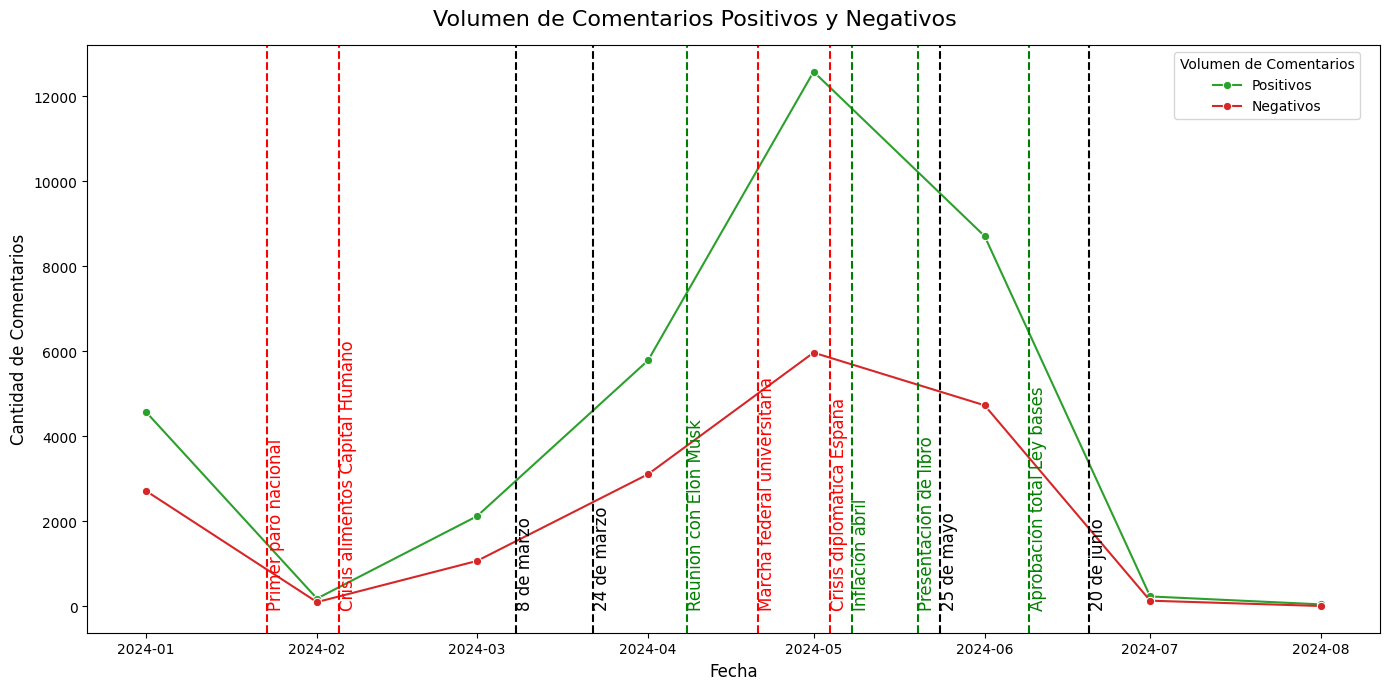

In [107]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Crear figura y ejes (solo un eje)
fig, ax = plt.subplots(figsize=(14, 7))

# Eje 2: Cantidad de comentarios positivos y negativos
color_positive = 'tab:green'
color_negative = 'tab:red'
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Cantidad de Comentarios', fontsize=12)

sns.lineplot(data=temporal_data, x='time_period', y='count_positive', marker='o', label='Positivos', color=color_positive, ax=ax)
sns.lineplot(data=temporal_data, x='time_period', y='count_negative', marker='o', label='Negativos', color=color_negative, ax=ax)

ax.tick_params(axis='y')

# Añadir título y leyenda
fig.suptitle('Volumen de Comentarios Positivos y Negativos', fontsize=16)
fig.tight_layout()

ax.legend(loc='upper right', bbox_to_anchor=(0.99, 1), title="Volumen de Comentarios")

# Función para asignar color basado en la clasificación
def asignar_color(tipo_evento):
    if tipo_evento == 'Favorable':
        return 'green'
    elif tipo_evento == 'Desfavorable':
        return 'red'
    else:
        return 'black'

# Asegurarse de que 'eventos' es una lista de diccionarios con la clave 'fecha' como cadena de texto
for evento in eventos_list:
    # Convertir fecha a Timestamp (asegurándonos de que es una cadena válida de fecha)
    fecha_evento = pd.to_datetime(evento["fecha"])  # Esto convierte la fecha en formato adecuado
    color_evento = asignar_color(evento["tipo_evento"])
    
    # Añadir línea vertical para el evento
    ax.axvline(fecha_evento, color=color_evento, linestyle='--', label=f'{evento["evento"]} ({evento["tipo_evento"]})')

    # Añadir anotación (horizontal, encima de la línea vertical)
    ax.annotate(evento["evento"], xy=(fecha_evento, 0.2), xytext=(fecha_evento, 0.5),  # Posición ajustada hacia arriba
                fontsize=12, color=color_evento, ha='left', rotation=90)

plt.show()


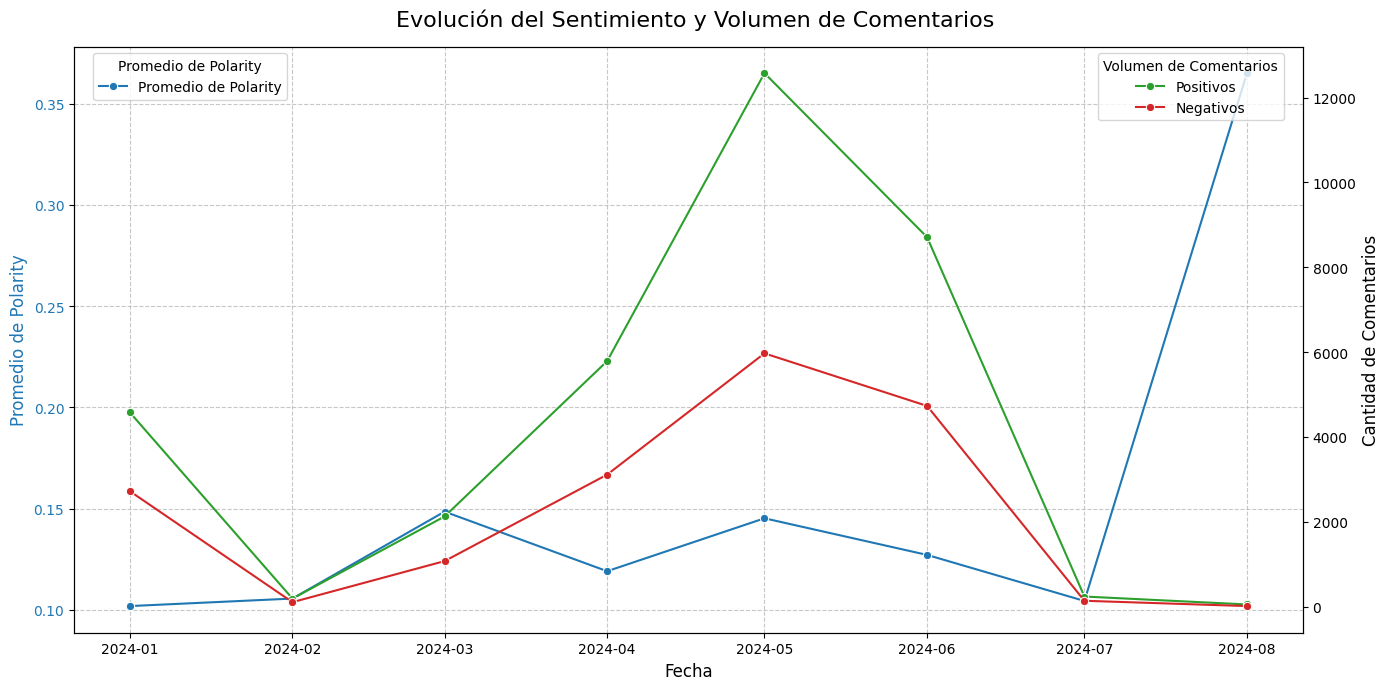

In [108]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje 1: Promedio de polarity
color = 'tab:blue'
ax1.set_xlabel('Fecha', fontsize=12)
ax1.set_ylabel('Promedio de Polarity', color=color, fontsize=12)
sns.lineplot(data=temporal_data, x='time_period', y='mean_polarity', marker='o', label='Promedio de Polarity', color=color, ax=ax1)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(visible=True, linestyle="--", alpha=0.7)

# Crear segundo eje compartido
ax2 = ax1.twinx()

# Eje 2: Cantidad de comentarios positivos y negativos
color_positive = 'tab:green'
color_negative = 'tab:red'
ax2.set_ylabel('Cantidad de Comentarios', fontsize=12)
sns.lineplot(data=temporal_data, x='time_period', y='count_positive', marker='o', label='Positivos', color=color_positive, ax=ax2)
sns.lineplot(data=temporal_data, x='time_period', y='count_negative', marker='o', label='Negativos', color=color_negative, ax=ax2)
ax2.tick_params(axis='y')

# Añadir títulos y leyendas
fig.suptitle('Evolución del Sentimiento y Volumen de Comentarios', fontsize=16)
fig.tight_layout()

# Añadir leyendas manualmente
ax1.legend(loc='upper left', bbox_to_anchor=(0.01, 1), title="Promedio de Polarity")
ax2.legend(loc='upper right', bbox_to_anchor=(0.99, 1), title="Volumen de Comentarios")

plt.show()


Versión semanal del gráfico

In [143]:
# Crear columna temporal agrupada por semana
df_inicial['week'] = df_inicial['comment_time'].dt.to_period('W')

# Calcular promedio de polarity por semana
temporal_trend = df_inicial.groupby('week')['polarity'].mean()

# Calcular volúmenes por semana
temporal_data = df_inicial.groupby('week').agg(
    mean_polarity=('polarity', 'mean'),
    count_positive=('polarity', lambda x: (x > 0).sum()),
    count_negative=('polarity', lambda x: (x < 0).sum())
).reset_index()

# Convertir la columna de semana a formato datetime para graficar
temporal_data['week'] = temporal_data['week'].dt.to_timestamp()




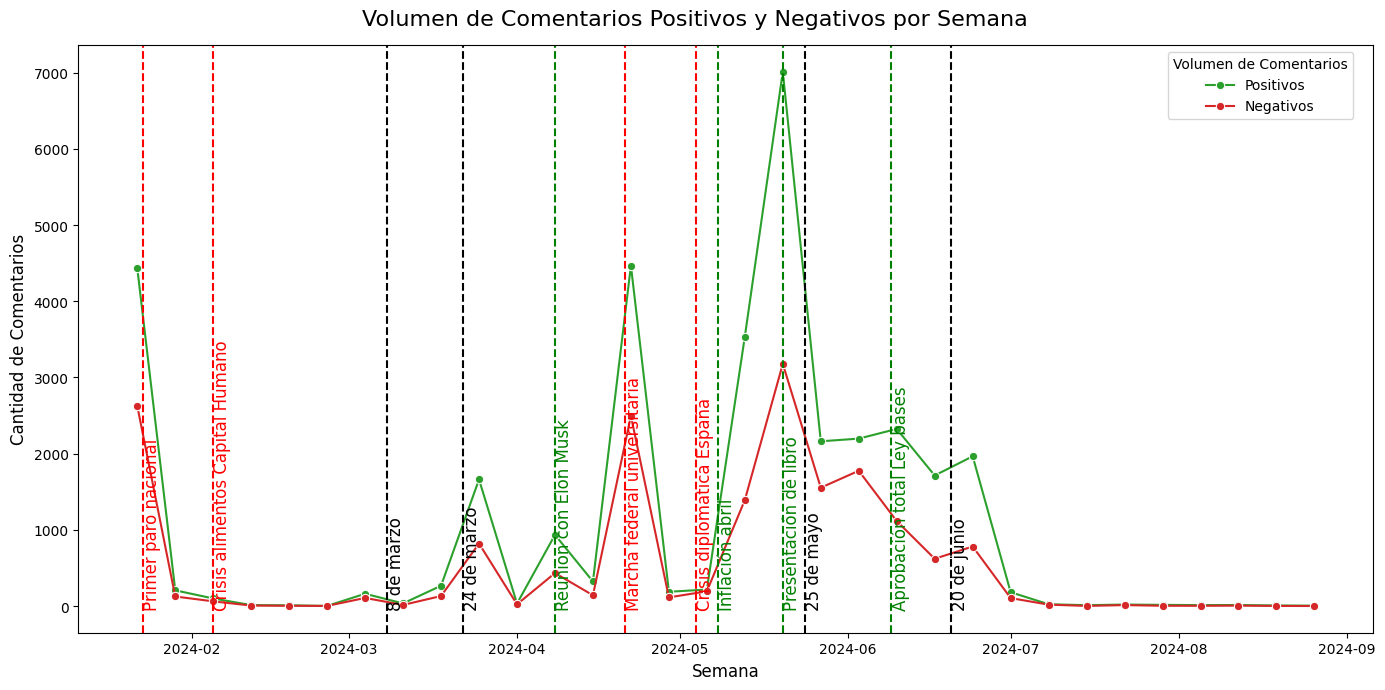

In [148]:
# Crear figura y ejes (solo un eje)
fig, ax = plt.subplots(figsize=(14, 7))

# Eje 2: Cantidad de comentarios positivos y negativos
color_positive = 'tab:green'
color_negative = 'tab:red'
ax.set_xlabel('Semana', fontsize=12)
ax.set_ylabel('Cantidad de Comentarios', fontsize=12)

# Graficar los comentarios positivos y negativos por semana
sns.lineplot(data=temporal_data, x='week', y='count_positive', marker='o', label='Positivos', color=color_positive, ax=ax)
sns.lineplot(data=temporal_data, x='week', y='count_negative', marker='o', label='Negativos', color=color_negative, ax=ax)

ax.tick_params(axis='y')

# Añadir título y leyenda
fig.suptitle('Volumen de Comentarios Positivos y Negativos por Semana', fontsize=16)
fig.tight_layout()

ax.legend(loc='upper right', bbox_to_anchor=(0.99, 1), title="Volumen de Comentarios")

# Función para asignar color basado en la clasificación
def asignar_color(tipo_evento):
    if tipo_evento == 'Favorable':
        return 'green'
    elif tipo_evento == 'Desfavorable':
        return 'red'
    else:
        return 'black'

# Asegurarse de que 'eventos' es una lista de diccionarios con la clave 'fecha' como cadena de texto
for evento in eventos_list:
    # Convertir fecha a Timestamp (asegurándonos de que es una cadena válida de fecha)
    fecha_evento = pd.to_datetime(evento["fecha"])  # Esto convierte la fecha en formato adecuado
    color_evento = asignar_color(evento["tipo_evento"])

    # Añadir línea vertical para el evento
    ax.axvline(fecha_evento, color=color_evento, linestyle='--', label=f'{evento["nombre"]} ({evento["tipo_evento"]})')

    # Añadir anotación (horizontal, encima de la línea vertical)
    ax.annotate(evento["nombre"], xy=(fecha_evento, 0.2), xytext=(fecha_evento, 0.5),  # Posición ajustada hacia arriba
                fontsize=12, color=color_evento, ha='left', rotation=90)

plt.show()


Comparamos el inicio y el final del dataset

In [7]:
# Calcular el punto medio del tiempo
midpoint = inicio + (final - inicio) / 2

# Dividir en dos períodos
inicio_periodo = df_inicial[df_inicial['comment_time'] < midpoint]['polarity']
final_periodo = df_inicial[df_inicial['comment_time'] >= midpoint]['polarity']

# Comparar estadísticas descriptivas
print("Inicio del período:")
print(inicio_periodo.describe())
print("\nFinal del período:")
print(final_periodo.describe())

# Prueba estadística (t-test)
t_stat, p_value = ttest_ind(inicio_periodo, final_periodo, equal_var=False)
print(f"T-test: t={t_stat}, p={p_value}")

# Alternativa no paramétrica
u_stat, p_value = mannwhitneyu(inicio_periodo, final_periodo)
print(f"Mann-Whitney U: u={u_stat}, p={p_value}")


Inicio del período:
count    20332.000000
mean         0.114592
std          0.415847
min         -1.000000
25%         -0.125000
50%          0.115000
75%          0.350000
max          1.000000
Name: polarity, dtype: float64

Final del período:
count    31757.000000
mean         0.139829
std          0.424312
min         -1.000000
25%         -0.104167
50%          0.136364
75%          0.400000
max          1.000000
Name: polarity, dtype: float64
T-test: t=-6.703172627341486, p=2.0640002335655644e-11
Mann-Whitney U: u=311959988.5, p=7.98576480075042e-11


division por eventos

In [149]:
# Suponiendo que eventos_list tiene una estructura similar a:
# eventos_list = [{"fecha": '2024-06-15', "tipo_evento": "negativo", "nombre": "Evento A"}, ...]

# Convertir las fechas de los eventos a formato datetime
eventos_list = [{'fecha': pd.to_datetime(evento['fecha']), 'tipo_evento': evento['tipo_evento'], 'nombre': evento['nombre']} for evento in eventos_list]

# Dividir los datos por los eventos
for evento in eventos_list:
    # Filtrar los comentarios antes y después de cada evento
    comentarios_antes = df_inicial[df_inicial['comment_time'] < evento['fecha']]['polarity']
    comentarios_despues = df_inicial[df_inicial['comment_time'] >= evento['fecha']]['polarity']
    
    # Estadísticas descriptivas
    print(f"Estadísticas para el evento: {evento['nombre']}")
    print("Comentarios antes del evento:")
    print(comentarios_antes.describe())
    print("\nComentarios después del evento:")
    print(comentarios_despues.describe())
    
    # Prueba estadística (T-test)
    t_stat, p_value = ttest_ind(comentarios_antes, comentarios_despues, equal_var=False)
    print(f"T-test: t={t_stat}, p={p_value}")
    
    # Prueba no paramétrica (Mann-Whitney U)
    u_stat, p_value = mannwhitneyu(comentarios_antes, comentarios_despues)
    print(f"Mann-Whitney U: u={u_stat}, p={p_value}")
    print("\n" + "-"*50)


Estadísticas para el evento: 20 de junio
Comentarios antes del evento:
count    46957.000000
mean         0.124045
std          0.421518
min         -1.000000
25%         -0.125000
50%          0.125000
75%          0.375000
max          1.000000
Name: polarity, dtype: float64

Comentarios después del evento:
count    5132.000000
mean        0.184270
std         0.414430
min        -1.000000
25%        -0.050000
50%         0.175000
75%         0.441667
max         1.000000
Name: polarity, dtype: float64
T-test: t=-9.867664231114803, p=8.382743383384883e-23
Mann-Whitney U: u=110391331.0, p=5.2347484077025356e-23

--------------------------------------------------
Estadísticas para el evento: 24 de marzo
Comentarios antes del evento:
count    7902.000000
mean        0.102406
std         0.413764
min        -1.000000
25%        -0.139877
50%         0.100000
75%         0.333333
max         1.000000
Name: polarity, dtype: float64

Comentarios después del evento:
count    44187.000000
mea

C:\Users\User\AppData\Local\Temp\ipykernel_5180\4126980560.py:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = ttest_ind(comentarios_antes, comentarios_despues, equal_var=False)
C:\Users\User\AppData\Local\Temp\ipykernel_5180\4126980560.py:25: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value = mannwhitneyu(comentarios_antes, comentarios_despues)


Tendencia estadistica

-----------------------------------------------------

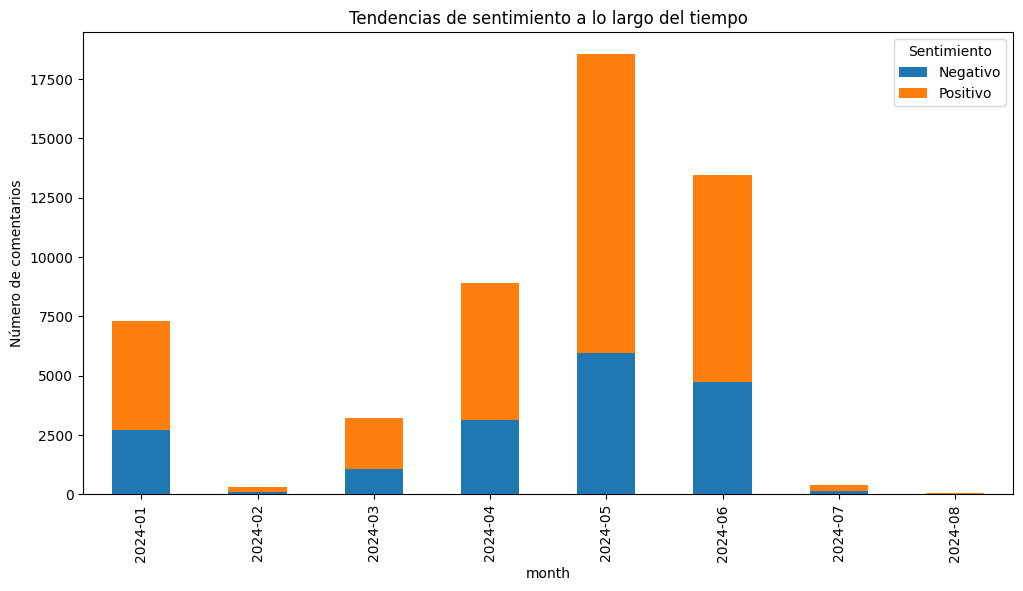

In [150]:
# Convertir fechas
df_inicial['comment_time'] = pd.to_datetime(df_inicial['comment_time'])
df_inicial['video_published_at'] = pd.to_datetime(df_inicial['video_published_at'])

# Eliminar comentarios neutros
df_inicial = df_inicial[df_inicial['polarity'] != 0]

# Crear columna temporal agrupada (e.g., por mes)
df_inicial['month'] = df_inicial['comment_time'].dt.to_period('M')

# Visualización de cambios en el tiempo
sentiment_trends = df_inicial.groupby(['month', 'Sentimiento']).size().unstack().fillna(0)
sentiment_trends.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Tendencias de sentimiento a lo largo del tiempo")
plt.ylabel("Número de comentarios")
plt.show()

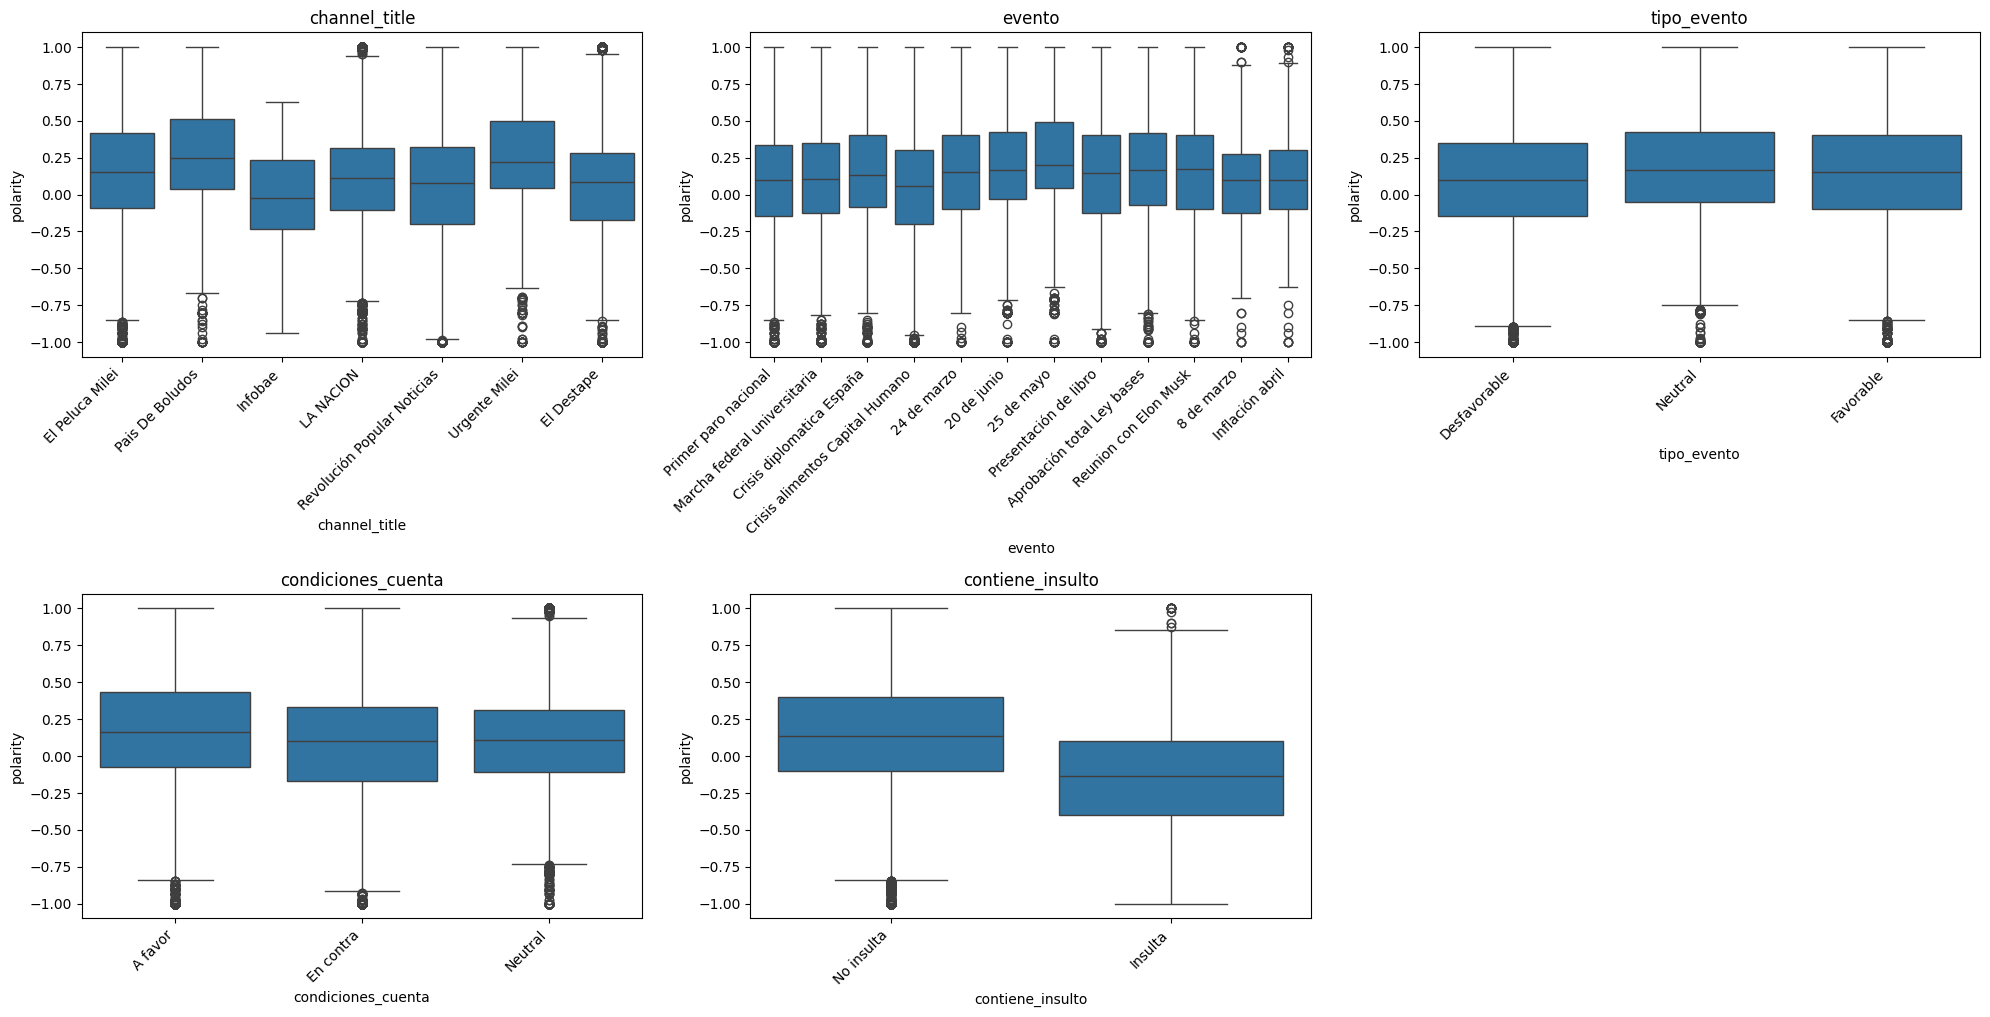

In [151]:
# Creamos una figura general para ver los gráficos
plt.figure(figsize=(20, 15))

# Hacemos un boxplot para cada una de las columnas categoricas
for i, columna in enumerate(columnas_categoricas, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=columna, y='polarity', data=df_inicial)
    plt.title(columna)
    plt.xticks(rotation=45, ha='right') 

# Ajustamos el tamaño del gráfico
plt.tight_layout()
plt.show()


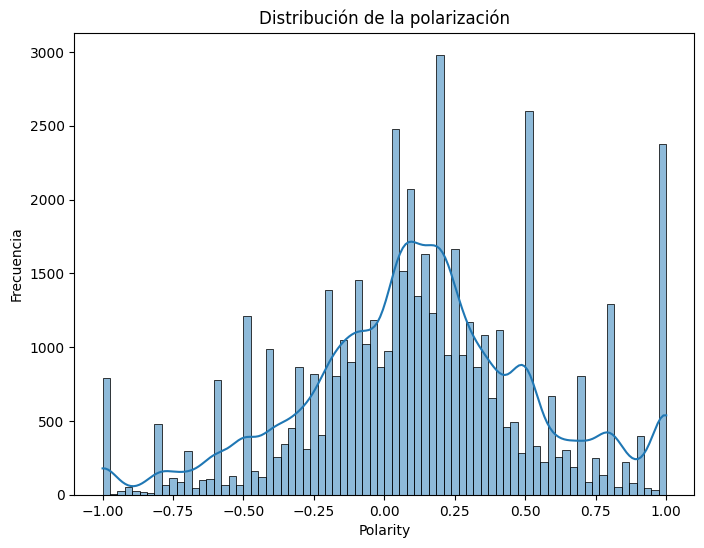

In [152]:
# Aprovechamos para visualizar la distribución de salario
plt.figure(figsize=(8, 6))
sns.histplot(df_inicial['polarity'], kde=True)
plt.title('Distribución de la polarización')
plt.xlabel('Polarity')
plt.ylabel('Frecuencia')
plt.show()

# Analasis de cambio estadisticamente significativo en el apoyo de Milei

Modelo 1: Analisis de influencias de las variables

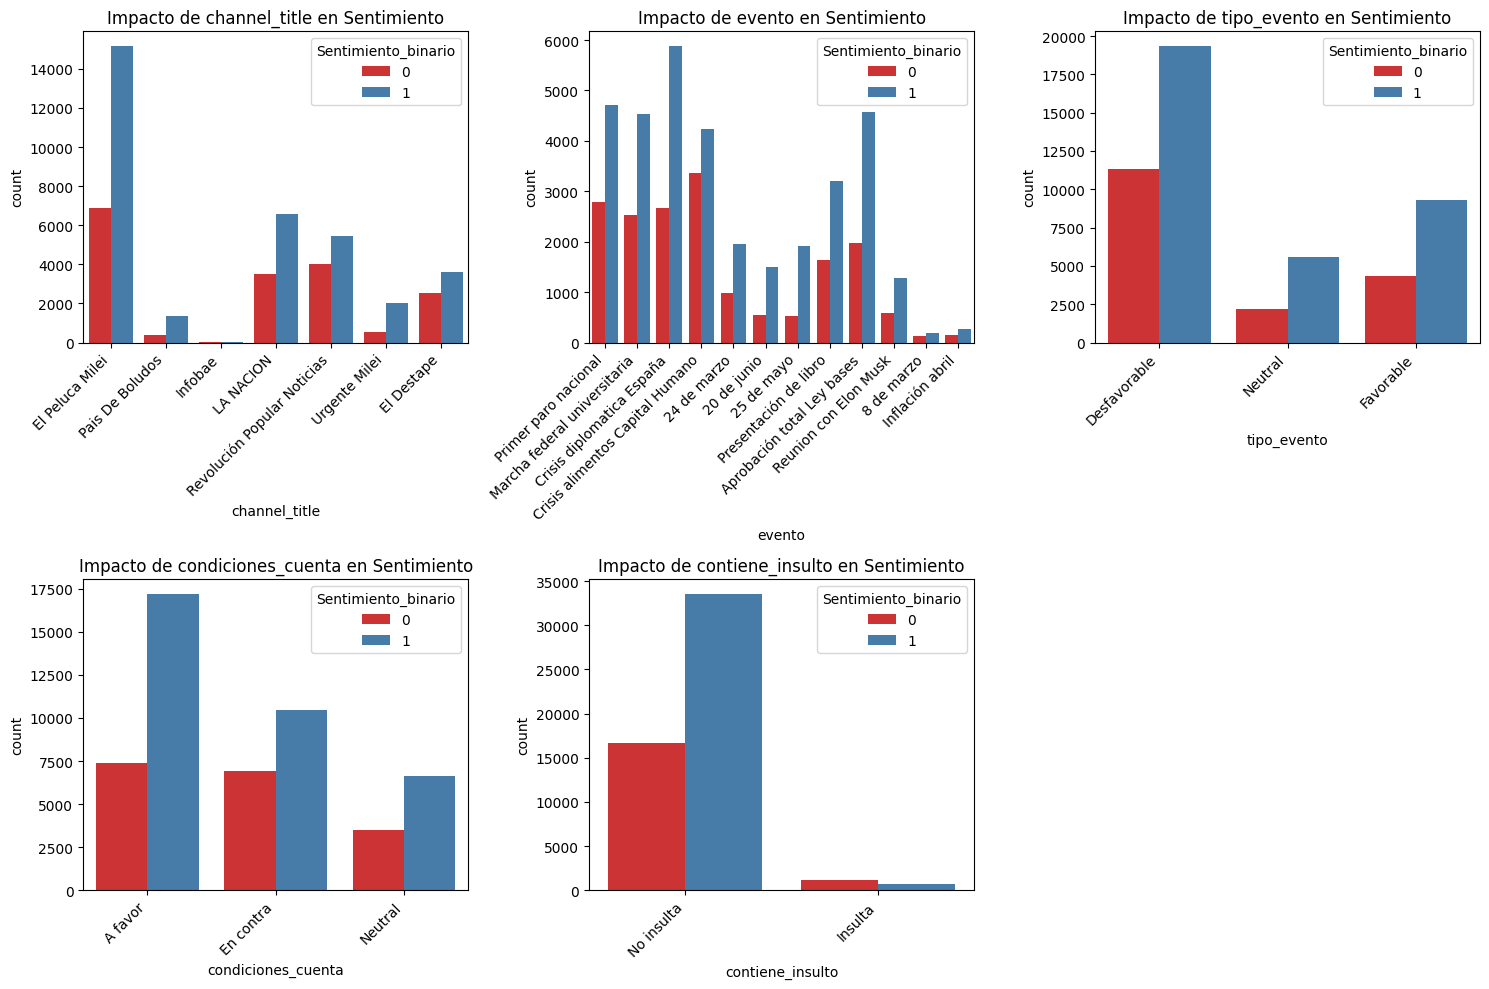

In [154]:
## Crear un nuevo DataFrame sin modificar el original
df_sentimiento = df_inicial.copy()

# Convertir la columna 'Sentimiento' a binaria (1 = Positivo, 0 = Negativo)
df_sentimiento['Sentimiento_binario'] = df_sentimiento['Sentimiento'].map({'Positivo': 1, 'Negativo': 0})

# Variables categóricas
categorical_vars = ['channel_title', 'evento', 'tipo_evento', 'condiciones_cuenta', 'contiene_insulto']

# Analizar la relación de las variables categóricas con la variable binaria 'Sentimiento_binario'
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de barras para cada variable categórica frente al Sentimiento
plt.figure(figsize=(15, 10))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 3, i)  # Crear subgráficos
    sns.countplot(x=var, hue='Sentimiento_binario', data=df_sentimiento, palette="Set1")
    plt.title(f'Impacto de {var} en Sentimiento')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()



In [156]:
from scipy.stats import chi2_contingency

# Análisis Chi-cuadrado para cada variable categórica
chi_results = {}

for var in categorical_vars:
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(df_sentimiento[var], df_sentimiento['Sentimiento_binario'])
    
    # Realizar prueba Chi-cuadrado
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    # Guardar los resultados
    chi_results[var] = {
        'chi2': chi2,
        'p_value': p_value
    }

# Mostrar resultados
for var, result in chi_results.items():
    print(f"Análisis Chi-cuadrado para {var}:")
    print(f"Chi-cuadrado: {result['chi2']:.4f}, p-valor: {result['p_value']:.4f}")
    print("-" * 50)


Análisis Chi-cuadrado para channel_title:
Chi-cuadrado: 818.0958, p-valor: 0.0000
--------------------------------------------------
Análisis Chi-cuadrado para evento:
Chi-cuadrado: 702.6981, p-valor: 0.0000
--------------------------------------------------
Análisis Chi-cuadrado para tipo_evento:
Chi-cuadrado: 273.3275, p-valor: 0.0000
--------------------------------------------------
Análisis Chi-cuadrado para condiciones_cuenta:
Chi-cuadrado: 429.9575, p-valor: 0.0000
--------------------------------------------------
Análisis Chi-cuadrado para contiene_insulto:
Chi-cuadrado: 739.9771, p-valor: 0.0000
--------------------------------------------------


Modelo 2: random forest

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Aseguramos que 'Sentimiento' esté en formato binario
le = LabelEncoder()
df_sentimiento['Sentimiento_binario'] = le.fit_transform(df_sentimiento['Sentimiento'])

# Variables predictoras y la variable objetivo
X = df_sentimiento[categorical_vars]  # Las variables categóricas
y = df_sentimiento['Sentimiento_binario']  # La variable objetivo (Sentimiento binario)

# Crear variables dummy para las categorías
X_encoded = pd.get_dummies(X, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Entrenar el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_model.predict(X_test)


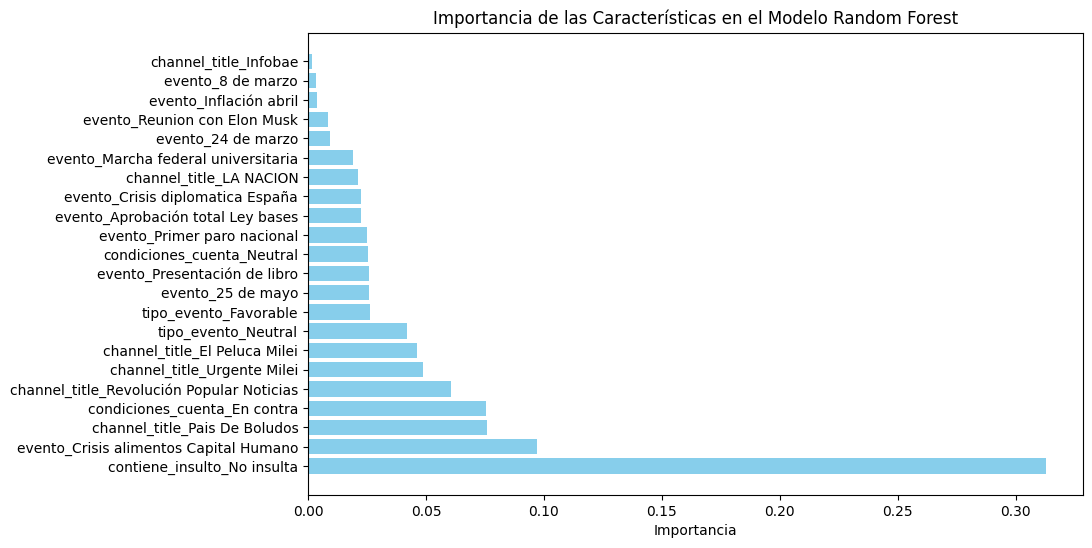

,Feature,Importance
21,contiene_insulto_No insulta,0.312798
10,evento_Crisis alimentos Capital Humano,0.097179
3,channel_title_Pais De Boludos,0.075823
19,condiciones_cuenta_En contra,0.075604
4,channel_title_Revolución Popular Noticias,0.060778
5,channel_title_Urgente Milei,0.048864
0,channel_title_El Peluca Milei,0.046291
18,tipo_evento_Neutral,0.041832
17,tipo_evento_Favorable,0.026159
7,evento_25 de mayo,0.025997


In [158]:
# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un dataframe para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
})

# Ordenar las importancias de mayor a menor
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.show()

# Mostrar el dataframe de importancias
importance_df


Dado que "contiene_insulto_No insulta" tiene la mayor importancia, podemos inferir que esta variable es muy relevante para predecir si un comentario tiene un sentimiento positivo o negativo. Esto tiene sentido, ya que la presencia de insultos podría afectar considerablemente la percepción del sentimiento de un comentario.

En cuanto a las otras variables, como "evento" y "channel_title", cada una de sus categorías aporta algo al modelo.

Nueva visualizacion y modelo

In [128]:
# Crear un nuevo dataframe temporal
df_temporal = df_inicial.copy()

# Asegurarse de que 'comment_time' esté en formato datetime
df_temporal['comment_time'] = pd.to_datetime(df_temporal['comment_time'])

# Añadir una columna para marcar los eventos clave en las fechas
def es_evento(fecha_comentario):
    # Verificar si la fecha del comentario cae dentro de un evento
    for evento in eventos_list:
        if evento['fecha'] <= fecha_comentario <= pd.Timestamp(evento['fecha']) + pd.Timedelta(days=7):
            return True
    return False

df_temporal['es_evento'] = df_temporal['comment_time'].apply(es_evento)


In [131]:
df_temporal = df_temporal.dropna(subset=['user_name'])



In [132]:
df_temporal.isnull().sum()


comment_id              0
comment                 0
user_id                 0
user_name               0
comment_time            0
comment_likes           0
total_reply_count       0
is_top_level_comment    0
video_title             0
channel_title           0
video_published_at      0
video_views             0
video_likes             0
relacion_evento         0
evento                  0
tipo_evento             0
condiciones_cuenta      0
duration_timedelta      0
duration_seconds        0
translated_text         0
polarity                0
Sentimiento             0
contiene_insulto        0
time_period             0
week                    0
month                   0
es_evento               0
dtype: int64

In [137]:
df_temporal = df_temporal.reset_index(drop=True)




In [138]:
df_temporal['comment_time'] = pd.to_datetime(df_temporal['comment_time'], errors='coerce')


In [139]:
# Convertir 'Sentimiento' en variable binaria (0 = Negativo, 1 = Positivo)
df_temporal['Sentimiento'] = df_temporal['Sentimiento'].map({'Negativo': 0, 'Positivo': 1})

# Filtrar las variables categóricas
categorical_vars = ['channel_title', 'evento', 'tipo_evento', 'condiciones_cuenta', 'contiene_insulto']

# Realizar análisis Chi-cuadrado para cada variable categórica
from scipy.stats import chi2_contingency

for var in categorical_vars:
    print(f"Análisis Chi-cuadrado para {var}:")
    
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(df_temporal[var], df_temporal['Sentimiento'])
    
    # Calcular chi-cuadrado
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"Chi-cuadrado: {chi2}, p-valor: {p_value}")
    print("-" * 50)


Análisis Chi-cuadrado para channel_title:
Chi-cuadrado: 815.9228793162883, p-valor: 5.583869374725369e-173
--------------------------------------------------
Análisis Chi-cuadrado para evento:
Chi-cuadrado: 700.0928347918536, p-valor: 5.153284103816442e-143
--------------------------------------------------
Análisis Chi-cuadrado para tipo_evento:
Chi-cuadrado: 272.35249157585315, p-valor: 7.234489455876964e-60
--------------------------------------------------
Análisis Chi-cuadrado para condiciones_cuenta:
Chi-cuadrado: 429.8402618337489, p-valor: 4.5853563548087533e-94
--------------------------------------------------
Análisis Chi-cuadrado para contiene_insulto:
Chi-cuadrado: 737.8177122224466, p-valor: 1.7877152698357467e-162
--------------------------------------------------
